# **Telco Churn - EDA & Model**

<figure>
  <center>
  <img src="https://miro.medium.com/v2/resize:fit:875/1*Xj5QTBN7umWESE_YrrDlhw.png" width=550 height=150/>
  
  </center>
</figure> 


### **Context**
This dataset provides a unique opportunity to analyze customer behavior and identify patterns related to customer retention and churn. It includes data from a sample of IBM customers and is a great resource for developing focused retention strategies.

### **Content**
Each row represents an individual customer, and each column provides specific attributes about the customer. The dataset includes:

- **Churn Information**: Indicates whether the customer left within the last month (column Churn).
- **Service Details**: Information about the services the customer has subscribed to, such as:
  - Phone and multiple lines
  - Internet service, online security, online backup, device protection
  - Technical support, streaming TV, and streaming movies
- **Account Details**: Includes customer tenure, contract type, payment method, paperless billing status, monthly charges, and total charges.
- **Demographic Information**: Covers gender, age range, marital status (partners), and dependent status.

**Inspiration**

This dataset provides an excellent foundation for exploring models related to customer churn prediction and retention strategies. It encourages a deeper understanding of customer behavior and the factors influencing churn.

**Objectives**

In this project, I aim to conduct an Exploratory Data Analysis (EDA) to uncover key insights and answer questions such as:

1. What percentage of customers are churning versus those who remain active?
2. Are there noticeable patterns in churned customers based on the services they use?
3. Does churn behavior vary significantly across genders?
4. How do churn rates differ between customers who pay monthly versus those on annual plans?
5. Which service types are the most profitable?
6. How much revenue is lost due to churned customers?
7. What is the average age of customers using paperless billing? Are they more prone to churn?
8. Other questions that may arise during exploration.

**Next Steps**

After the EDA, I will:

1. Build a Machine Learning Pipeline: To test various models and find the one that best fits our data.
2. Evaluate Model Performance: Use appropriate metrics to validate and compare model performance.
3. Predict Churn: Based on the best-performing model, predict customer churn and assess its practical applications.

I hope you enjoy this kernel as much as I enjoyed working on it! Let's dive into the analysis and discover meaningful insights. 🚀

Link for the dataset [Telco Churn](https://www.kaggle.com/datasets/blastchar/telco-customer-churn/data)

## 1. Set-Up

### 1.1 Import Libraries

In [1]:
# To handle the data
import pandas as pd
import numpy as np

# To visualize the data
import matplotlib.pyplot as plt
import seaborn as sns

# To handle warnings
import warnings

# Confiure warnings to be ignored
warnings.filterwarnings('ignore')

# Print all columns
pd.set_option('display.max_columns', None)

# plt Print Style
sns.set_style('darkgrid',{'grid.color': '.6', 'grid.linestyle': ':'})

"""Seed"""
seed = 42

### 1.2 Import Data

In [2]:
# Load the dataset
df = pd.read_csv('D:\Jupyter\Proyectos\Churn\Data\WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Print first 5 rows
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### 1.3 Functions

In [3]:
def metricas(modelo, X_train, X_test, y_train, y_test):
  """
    Calculates and returns performance metrics for a given model on the training and test datasets.

    Parameters:
    - model: The machine learning model to be evaluated.
    - X_train: The training dataset (features).
    - X_test: The test dataset (features).
    - y_train: True labels for the training set.
    - y_test: True labels for the test set.

    Returns:
    - A dataframe containing the performance metrics: accuracy on training, accuracy on test,
      precision and recall on the test set.
    """
  y_pred_train = modelo.predict(X_train)
  y_pred_test = modelo.predict(X_test)

  #Metricas en Train
  accuracy_train = accuracy_score(y_train, y_pred_train)
  precision_train = precision_score(y_train, y_pred_train)
  recall_train = recall_score(y_train, y_pred_train)

  #Metricas en Test
  accuracy_test = accuracy_score(y_test, y_pred_test)
  precision_test = precision_score(y_test, y_pred_test)
  recall_test = recall_score(y_test, y_pred_test)

  results = pd.DataFrame({'Accuracy':[accuracy_train, accuracy_test],
              'Precision':[precision_train, precision_test],
              'Recall':[recall_train, recall_test]}, index=['Train', 'Test'])

  return results

def curva_roc(modelo, X_test, y_test):
  """
    Calculates and displays the ROC curve for the test dataset using the provided model.

    Parameters:
    - model: A machine learning model with the `predict_proba` method.
    - X_test: The test dataset (features) for making predictions.
    - y_test: True labels for the test set.

    Notes:
    - It is assumed that the model has a `predict_proba` method that returns the probabilities for the positive class in the second column.
    - The function displays the ROC curve and the area under the curve (AUC).
    """
  # Obtener las probabilidades de la clase positiva para el conjunto de prueba
  y_test_prob = modelo.predict_proba(X_test)[:, 1]

  # Calcular la curva ROC
  fpr, tpr, thresholds = roc_curve(y_test.astype(int), y_test_prob)

  # Calcular el ROC AUC para el conjunto de prueba
  roc_auc_test = roc_auc_score(y_test, y_test_prob)

  # Crear y mostrar la visualización de la curva ROC
  plt.figure(figsize=(8, 6))
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc_test:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlabel('Tasa de Falsos Positivos (FPR)')
  plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
  plt.title('Curva ROC')
  plt.legend(loc='lower right')
  plt.show()

def barplots(subplots_number, feature_list):
  """
  This function generates multiple bar plots showing the relationship between
  the features in `feature_list` and the target variable 'Churn'.

  Parameters:
  subplots_number (int): The number of subplots to create, which corresponds to the number of features in `feature_list`.
  feature_list (list): A list of column names from the dataframe to be plotted against the 'Churn' column. 
                         Each feature will be plotted as a separate histogram in a subplot.

  The function will create a series of histograms, with each subplot showing a comparison of the feature
  (from `feature_list`) with the 'Churn' variable, using a 'dodge' hue for categorizing data points.
    
  Example:
  features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']
  barplots(4, features)
    
  This would create 4 subplots, one for each feature ('gender', 'SeniorCitizen', etc.) compared with 'Churn'.
  """
    
  plt.subplots(1, subplots_number, figsize=(20, 4))

  # Iterate through the features in feature_list
  for i, feature in enumerate(feature_list):
      plt.subplot(1, subplots_number, i + 1)  # Set the position of the subplot
      sns.histplot(data=df, hue=feature, x='Churn', multiple='dodge', shrink=0.8)
      plt.title(f'{feature} vs Churn')

  plt.tight_layout()
  plt.show()

def pie_charts_for_features(feature_list):
  """
  This function generates pie charts showing the distribution of each feature in `feature_list`
  for customers who have churned ('Churn' == 'Yes').

  Parameters:
  feature_list (list): A list of column names from the dataframe to be plotted as pie charts. 
                       Each feature will be plotted as a separate pie chart showing the distribution 
                       of the feature values for customers who have churned.
    
  Example:
  features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']
  pie_charts_for_features(features)
  
  This would create pie charts for the 'gender', 'SeniorCitizen', etc., features showing their distribution
  for customers who have churned.
  """
    
  plt.subplots(1, len(feature_list), figsize=(20, 4))

  # Iterate through the features in feature_list
  for i, feature in enumerate(feature_list):
      # Filter the data for customers who have churned
      feature_data = df[df['Churn'] == 'Yes'][feature].value_counts().reset_index()
       
      # Set the subplot for each pie chart
      plt.subplot(1, len(feature_list), i + 1)
      plt.pie(feature_data['count'], labels=feature_data[feature], startangle=90, autopct='%1.1f%%')
      plt.title(f'{feature} ("Churn")')

  plt.tight_layout()
  plt.show()



### 1.4 Dataset Attributes

- customerID - Customer ID
- gender - Whether the customer is a male or a female
- SeniorCitizen - Whether the customer is a senior citizen (1, 0)
- Partner - Whether the customer has a partner (Yes, No)
- Dependents - Whether the customer has dependents (Yes, No)
- tenure - Number of months the customer has stayed with the company
- PhoneService - Whether the customer has a phone service (Yes, No)
- MultipleLines - Whether the customer has multiple lines (Yes, No, No phone service)
- InternetService - Customer’s internet service provider (DSL, Fiber optic, No)
- OnlineSecurity - Whether the customer has online security (Yes, No, No internet service)
- OnlineBackup - Whether the customer has online backup or not (Yes, No, No internet service)
- DeviceProtection - Whether the customer has device protection (Yes, No, No internet service)
- TechSupport - Whether the customer has tech support (Yes, No, No internet service)
- StreamingTV - Whether the customer has streaming TV service (Yes, No, No internet service)
- StreamingMovies - Whether the customer has streaming movies service (Yes, No, No internet service)
- Contract - Indicates the type of the contract (Month-to-month, One year, Two year)
- PaperlessBilling - Whether the customer has paperless billing (Yes, No)
- PaymentMethod - Indicates the payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))
- MonthlyCharges - Indicates the current monthly subscription cost of the customer
- TotalCharges - Indicates the total charges paid by the customer so far
- Churn - Indicates whether the customer churned

## 2. EDA

In [4]:
# Exploring dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
# We ensure that the NaN values in the categorical variables are truly NaN.
var_categorica = df.select_dtypes(exclude='number').columns
for var in var_categorica:
    df[var] = df[var].replace('nan', np.nan)

In [6]:
# We iterate over all the columns to check for empty spaces or NaN values
for column in df.columns:
    if df[column].dtype in ['float64', 'int64']:
        df[column] = pd.to_numeric(df[column], errors='coerce')
    
    else:
        nulos  = df[column].isna().sum()
        vacios = (df[column].str.strip() == '').sum() 
        print(f'La Columna {column} tiene NaN: {nulos} y Vacios: {vacios}') 
    

La Columna customerID tiene NaN: 0 y Vacios: 0
La Columna gender tiene NaN: 0 y Vacios: 0
La Columna Partner tiene NaN: 0 y Vacios: 0
La Columna Dependents tiene NaN: 0 y Vacios: 0
La Columna PhoneService tiene NaN: 0 y Vacios: 0
La Columna MultipleLines tiene NaN: 0 y Vacios: 0
La Columna InternetService tiene NaN: 0 y Vacios: 0
La Columna OnlineSecurity tiene NaN: 0 y Vacios: 0
La Columna OnlineBackup tiene NaN: 0 y Vacios: 0
La Columna DeviceProtection tiene NaN: 0 y Vacios: 0
La Columna TechSupport tiene NaN: 0 y Vacios: 0
La Columna StreamingTV tiene NaN: 0 y Vacios: 0
La Columna StreamingMovies tiene NaN: 0 y Vacios: 0
La Columna Contract tiene NaN: 0 y Vacios: 0
La Columna PaperlessBilling tiene NaN: 0 y Vacios: 0
La Columna PaymentMethod tiene NaN: 0 y Vacios: 0
La Columna TotalCharges tiene NaN: 0 y Vacios: 11
La Columna Churn tiene NaN: 0 y Vacios: 0


In [7]:
# We convert TotalCharges to numeric and SeniorCitizen to Object
df['SeniorCitizen'] = df['SeniorCitizen'].astype('object')
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [8]:
# We search for duplicates
df[df.duplicated(keep=False)]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


In [9]:
# we search NaN columns
df.isna().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [10]:
# Describe the dataframe and transpose the result
describe = df.describe().T

# Add a column 'Nulos' that calculates the percentage of missing values for each column
describe['Nulos'] = (1 - (describe['count'] / df.shape[0])) * 100

# Display the description with missing values percentage
describe

,count,mean,std,min,25%,50%,75%,max,Nulos
tenure,7043.0,32.371149,24.559481,0.00,9.00,29.000,55.0000,72.00,0.000000
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.50,70.350,89.8500,118.75,0.000000
TotalCharges,7032.0,2283.300441,2266.771362,18.80,401.45,1397.475,3794.7375,8684.80,0.156183


<div style='border: 1px solid #ddd; padding: 10px; border-radius: 5px; background-color: #f9f9f9'>
    <ul>
        As we can see, the null values within the <b>TotalCharges</b> column represent less than 1%, so we can safely remove those rows.
    </ul>
</div>

In [11]:
# Removing null values
df = df.dropna()

In [12]:
# Removing customerID column, actually we dont need it
df = df.drop(columns=['customerID'])

In [13]:
"""
This code analyzes the categorical variables in the DataFrame by counting the occurrences of each value and calculating its percentage representation.
The result is a DataFrame displaying these metrics for each variable.
"""

# Select categorical variables by excluding numerical columns
var_catego = df.select_dtypes(exclude='number').columns

# Initialize an empty dictionary to store results
results = {}

# Loop through each categorical variable to analyze its values and their percentages
for var in var_catego:
    # Get the count of unique values in the column
    values = df[var].value_counts()
    
    # Get the percentage of each unique value in the column
    percen = df[var].value_counts(normalize=True) * 100
    
    # Store the counts and percentages in the results dictionary
    results[var] = pd.DataFrame({'values': values, 'percentage': percen})

# Concatenate all the results into a single DataFrame for easier viewing
pd.concat(results)

values  percentage
gender           Male                         3549   50.469283
                 Female                       3483   49.530717
SeniorCitizen    0                            5890   83.759954
                 1                            1142   16.240046
Partner          No                           3639   51.749147
                 Yes                          3393   48.250853
Dependents       No                           4933   70.150739
                 Yes                          2099   29.849261
PhoneService     Yes                          6352   90.329920
                 No                            680    9.670080
MultipleLines    No                           3385   48.137088
                 Yes                          2967   42.192833
                 No phone service              680    9.670080
InternetService  Fiber optic                  3096   44.027304
                 DSL                          2416   34.357224
                 No                           1520   21.615472
OnlineSecurity   No                           3497   49.729807
                 Yes                          2015   28.654721
                 No internet service          1520   21.615472
OnlineBackup     No                           3087   43.899317
                 Yes                          2425   34.485210
                 No internet service          1520   21.615472
DeviceProtection No                           3094   43.998862
                 Yes                          2418   34.385666
                 No internet service          1520   21.615472
TechSupport      No                           3472   49.374289
                 Yes                          2040   29.010239
                 No internet service          1520   21.615472
StreamingTV      No                           2809   39.945961
                 Yes                          2703   38.438567
                 No internet service          1520   21.615472
StreamingMovies  No                           2781   39.547782
                 Yes                          2731   38.836746
                 No internet service          1520   21.615472
Contract         Month-to-month               3875   55.105233
                 Two year                     1685   23.961889
                 One year                     1472   20.932878
PaperlessBilling Yes                          4168   59.271900
                 No                           2864   40.728100
PaymentMethod    Electronic check             2365   33.631968
                 Mailed check                 1604   22.810011
                 Bank transfer (automatic)    1542   21.928328
                 Credit card (automatic)      1521   21.629693
Churn            No                           5163   73.421502
                 Yes                          1869   26.578498

<div style='border: 1px solid #ddd; padding: 10px; border-radius: 5px; background-color: #f9f9f9'>
    <ul>
        The categorical variables are well-distributed, with no data points that stand out or require grouping.
    </ul>        
</div>

In [14]:
# Análisis de Variables Numéricas
results = {}
var_numericas = df.select_dtypes(include='number').columns
for var in var_numericas:
    conteo = df[var].nunique()
    results[var] = pd.DataFrame({'Count':conteo}, index=[''])
results = pd.concat(results)
results.sort_values(by='Count', ascending=True, inplace=True)
results


,,Count
tenure,,72
MonthlyCharges,,1584
TotalCharges,,6530


<div style='border: 1px solid #ddd; padding: 10px; border-radius= 5px; background-color: #f9f9f9'>
    <ul>
        We can observe that within the <b>tenure</b> variable, there are few unique values, which could lead us to consider converting it into a categorical variable. However, we will not proceed with this transformation at this point.
    </ul>
</div>
 

In [15]:
# # Creamos la nueva variable desde tenure
# df['tenure_category'] = pd.cut(df['tenure'], bins=[0,6,12,24,48,72],
#                                labels=['0-6 months', '6-12 months', '1-2 years', '2-4 years', '4-6 years'])

# # Eliminamos la variable tenure
# df = df.drop(columns=['tenure'])

# df.head()

### 2.1 Data Visualization

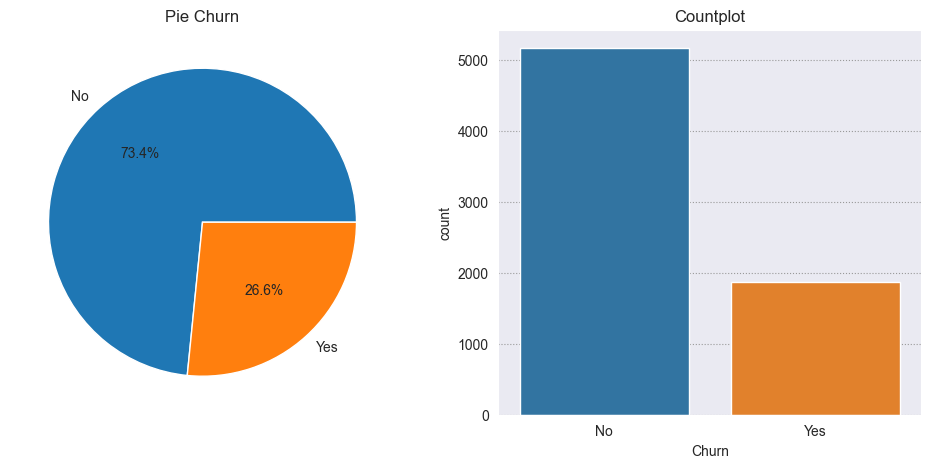

In [16]:
pie_churn = df['Churn'].value_counts(normalize=True).reset_index(name='percentage')

# Adjusting Pie Chart
plt.subplots(1,2,figsize=(12,5))

# Pie Chart
plt.subplot(1,2,1)
plt.pie(pie_churn['percentage'], labels=pie_churn['Churn'], autopct='%1.1f%%')
plt.title('Pie Churn')

# Countplot
plt.subplot(1,2,2)
sns.countplot(data=df, x='Churn', hue='Churn')
plt.title('Countplot')

plt.show()

<div style='border: 1px solid #ddd; padding: 10px; border-radius: 5px; background-color: #f9f9f9'>
    <ul>
        Based on the data, we can observe that approximately <b>26.6%</b> of customers cancel their contracts with the company. This highlights a notable rate of churn, which is important for understanding customer retention and addressing potential issues.
    </ul>        
</div>

#### 2.1.1 Customer Information

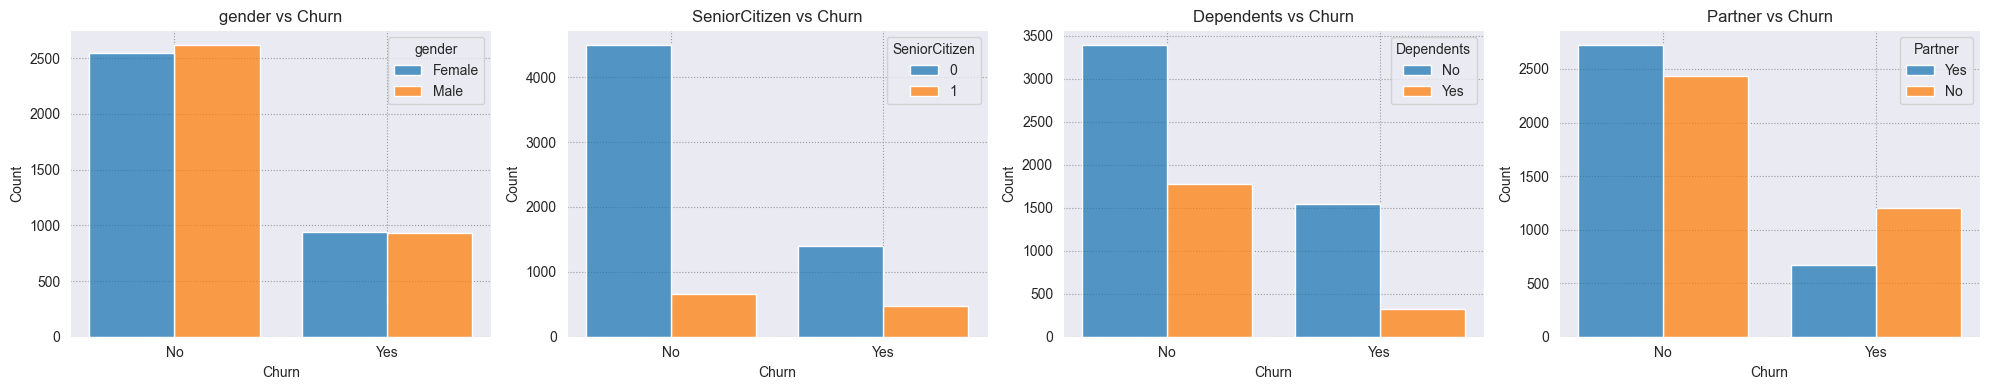

In [17]:
# Customer Information
list1 = ['gender', 'SeniorCitizen', 'Dependents', 'Partner']
barplots(len(list1), list1)

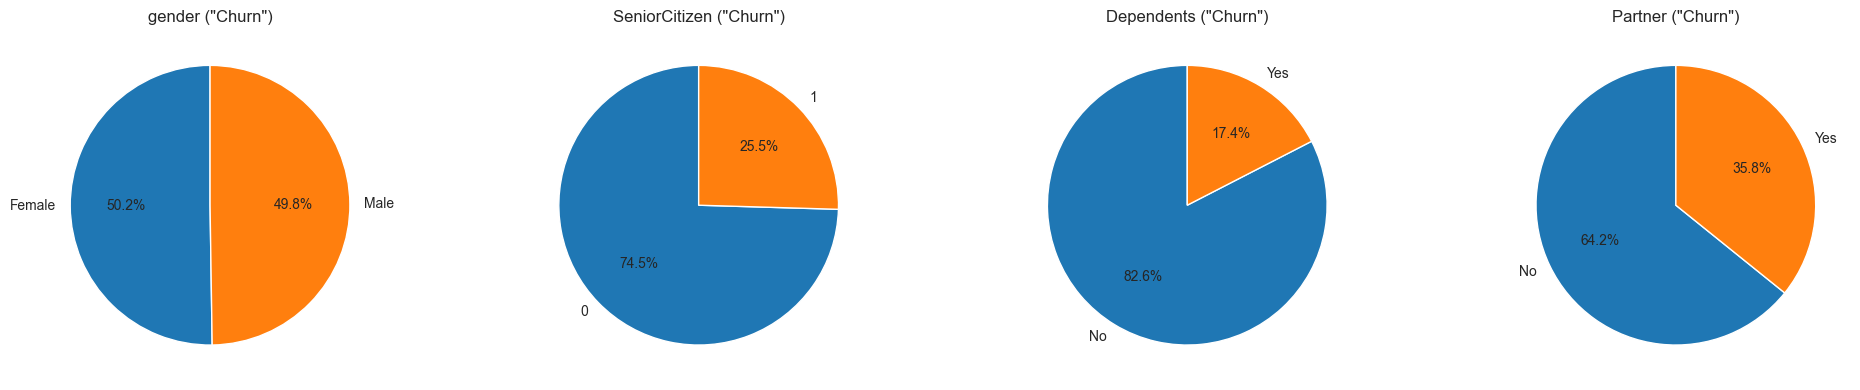

In [18]:
pie_charts_for_features(list1)

><div> The correlation between <b>gender</b> and the likelihood of churn appears to be minimal. However, more noteworthy associations emerge when examining the features of Partner, Dependents, and SeniorCitizen. These variables exhibit a more pronounced impact on churn rates, suggesting that customer relationships and demographics play a more significant role in predicting churn behavior.</div>

#### 2.1.2 Provided Services

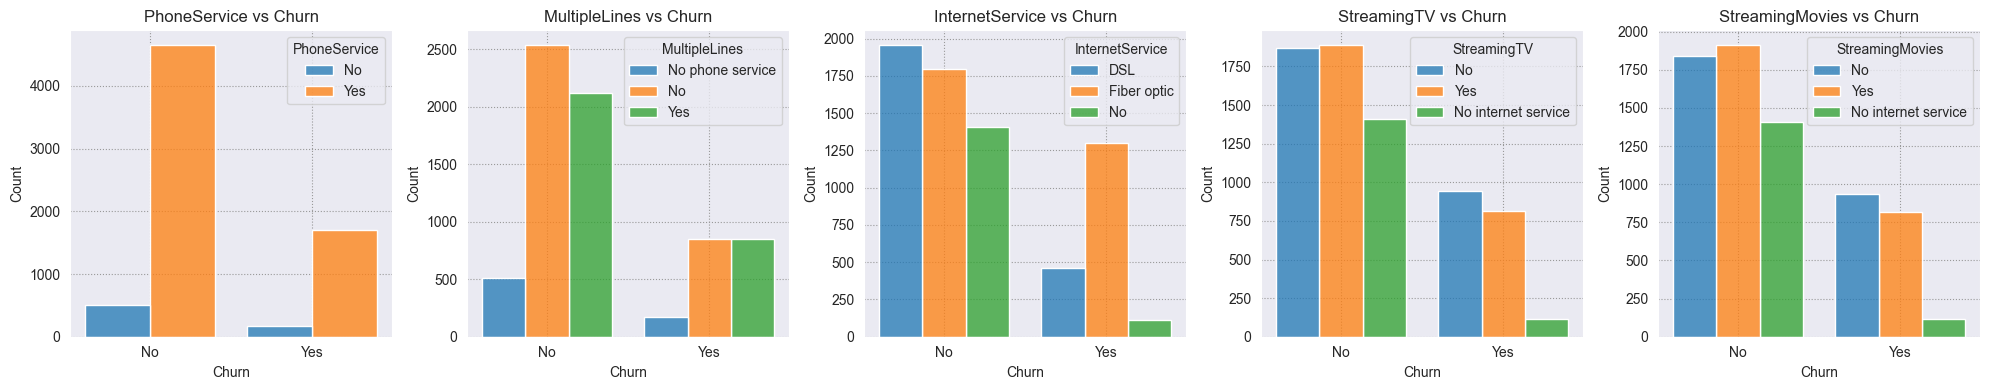

In [19]:
list2 = ['PhoneService', 'MultipleLines', 'InternetService', 'StreamingTV', 'StreamingMovies']

barplots(len(list2), list2)

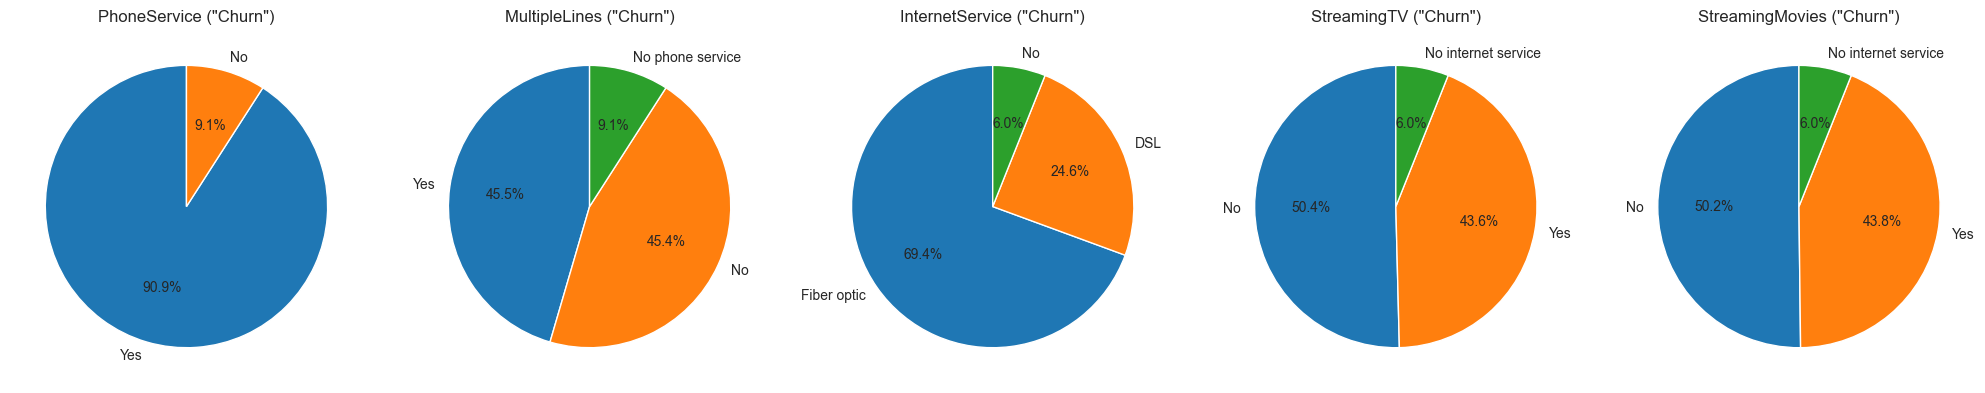

In [20]:
pie_charts_for_features(list2)

<div style="border: 1px solid #ddd; padding: 10px; border-radius: 5px; background-color: #f9f9f9;">
    <ul>
        <li><b>Fiber Users:</b> A high number of customers using Fiber internet service have a high churn rate, indicating potential dissatisfaction or issues with the service.</li>
        <li><b>DSL Users:</b> Customers with DSL internet show a significantly lower churn rate, suggesting higher satisfaction or loyalty within this group.</li>
        <li><b>Non-Internet Users:</b> Customers without internet have an extremely low churn rate, implying that they are less likely to leave the service.</li>
    </ul>
</div>


#### 2.1.4 Support Services

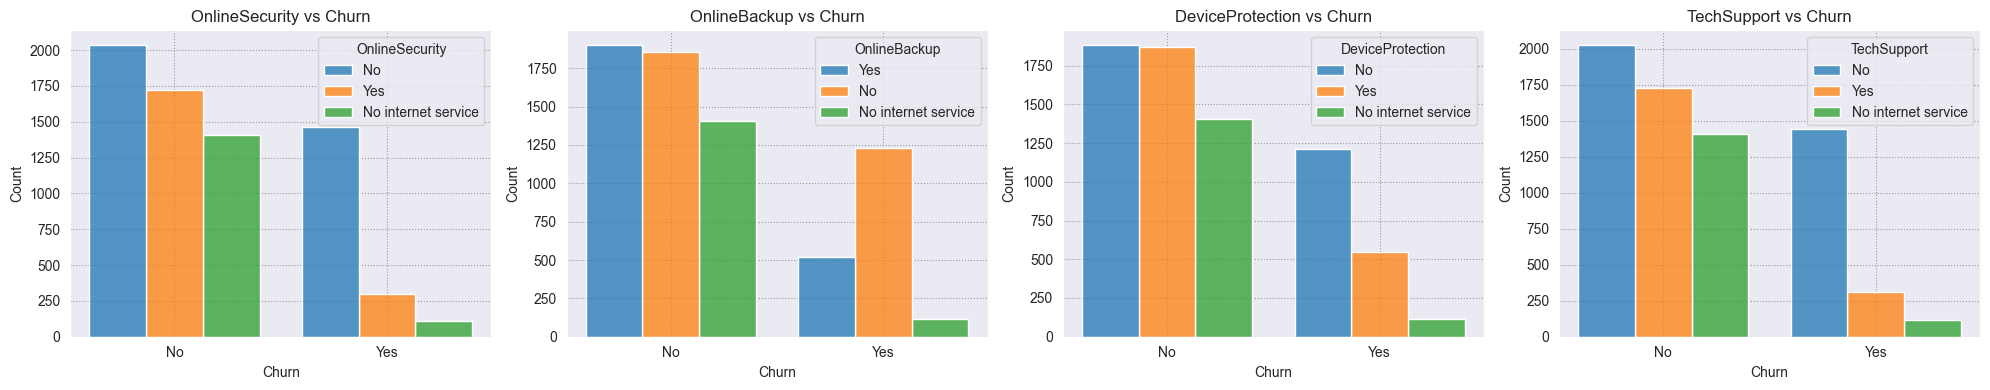

In [22]:
list3 = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport']

barplots(len(list3), list3)

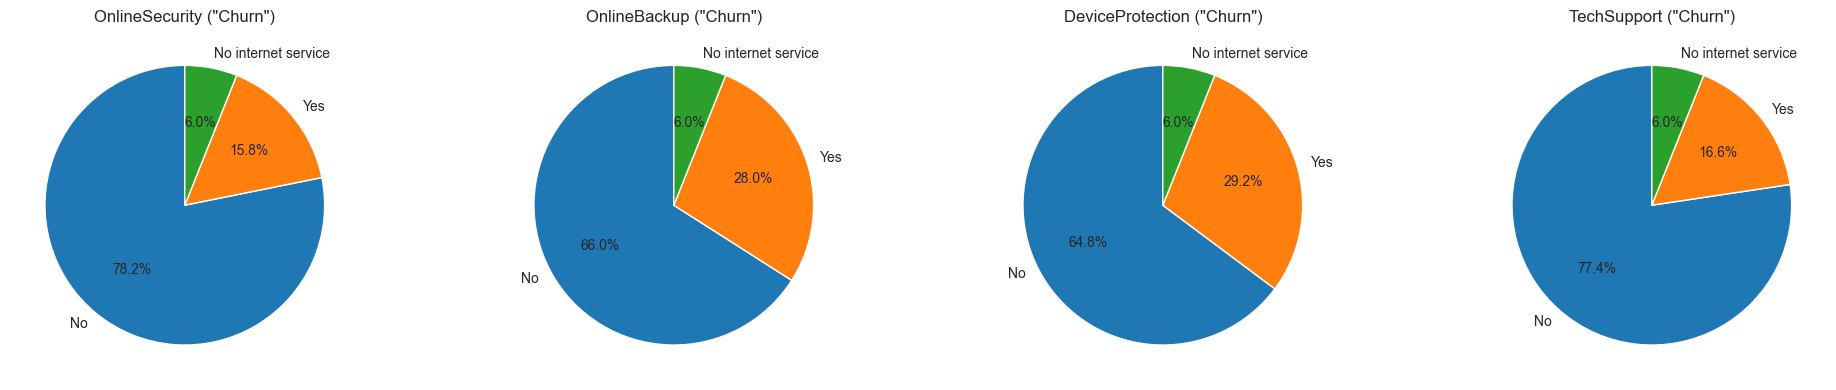

In [24]:
pie_charts_for_features(list3)

<div style="border: 1px solid #ddd; padding: 10px; border-radius: 5px; background-color: #f9f9f9;"
<ul>
    Customers who don't subscribe support services are more likely to churn.
<ul>
</div>

#### 2.1.5 Payments

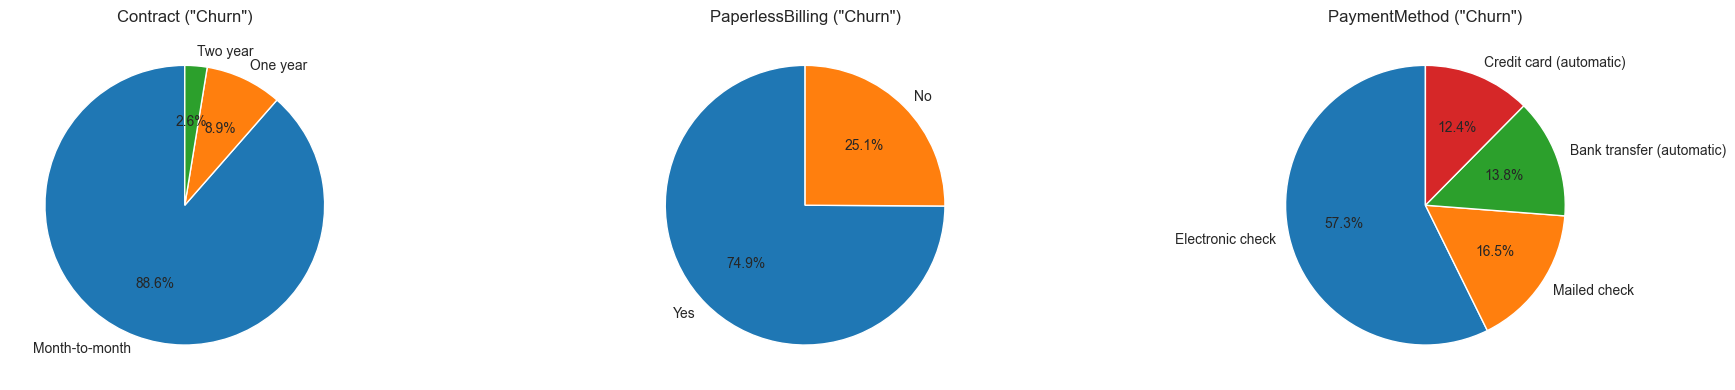

In [25]:
list4 = ['Contract', 'PaperlessBilling', 'PaymentMethod']
pie_charts_for_features(list4)

<div style="border: 1px solid #ddd; padding: 10px; border-radius: 5px; background-color: #f9f9f9;">
    <ul>
        <li>Short term contracts have much higher churn rates.</li>
        <li>Customers with paperless billing are more probable to churn.</li>
        <li>Customers with electronic check as a payment method are much more likely to churn.</li>
    </ul>
</div>

#### 2.1.6 Numerical Features vs Target

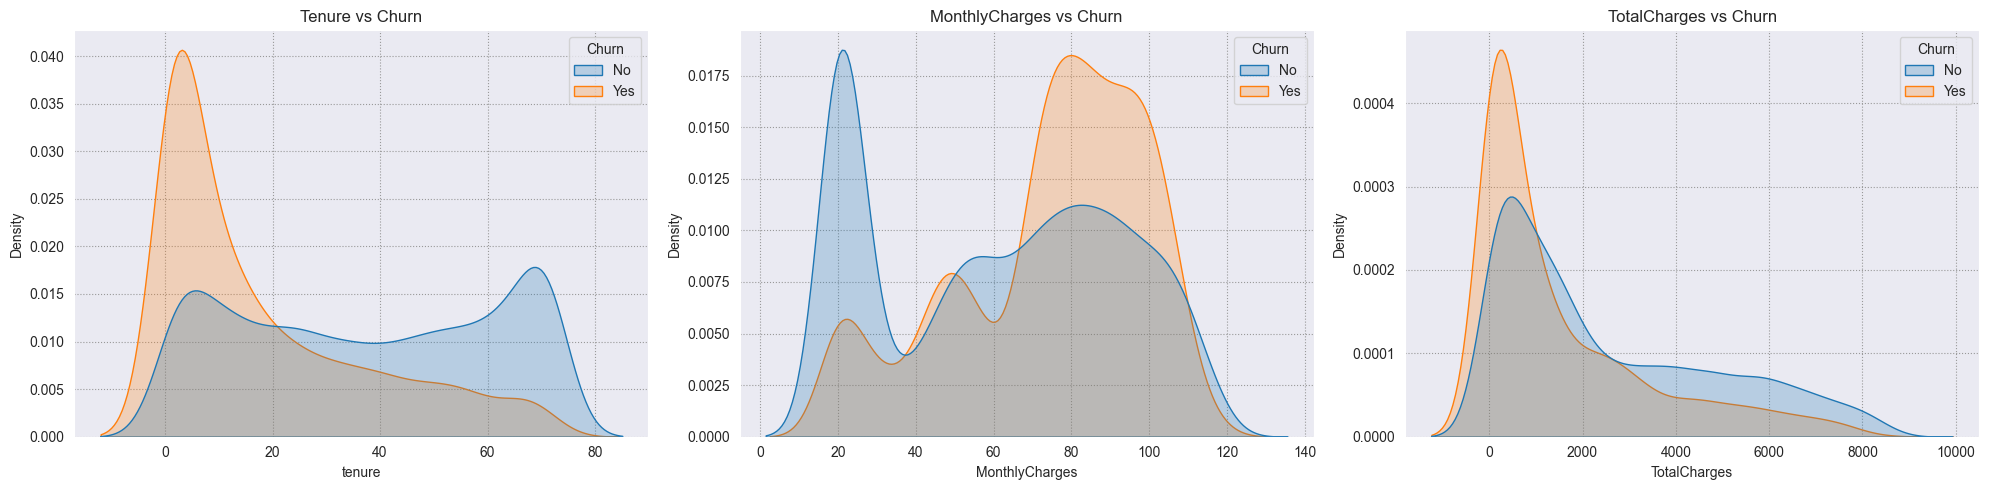

In [26]:
# Numerical Features 
plt.subplots(1,3,figsize=(20,5))

# Plot tenure
plt.subplot(1,3,1)
sns.kdeplot(data=df, x='tenure', hue='Churn', common_norm=False, fill=True)
plt.title('Tenure vs Churn')

# Plot MonthlyCharges
plt.subplot(1,3,2)
sns.kdeplot(data=df, x='MonthlyCharges', hue='Churn', common_norm=False, fill=True)
plt.title('MonthlyCharges vs Churn')

# Plot TotalCharges
plt.subplot(1,3,3)
sns.kdeplot(data=df, x='TotalCharges', hue='Churn', common_norm=False, fill=True)
plt.title('TotalCharges vs Churn')

plt.tight_layout()
plt.show()

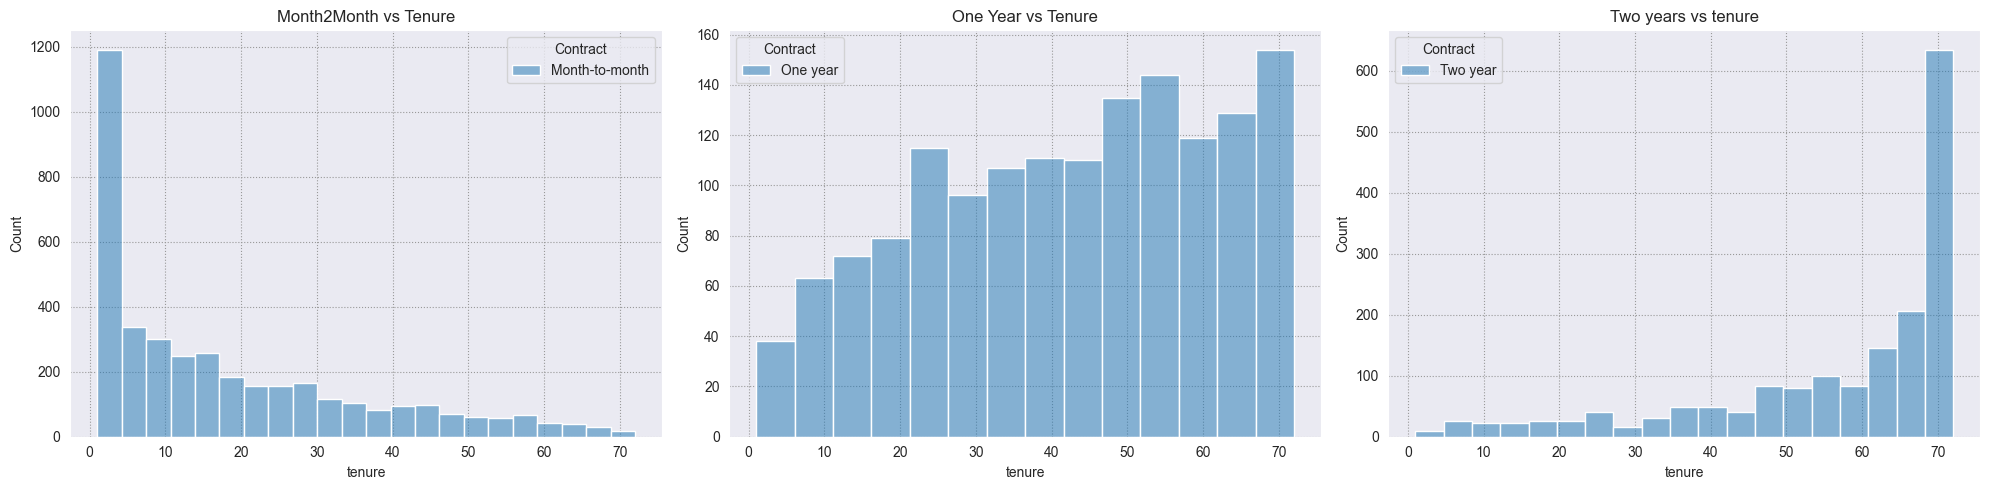

In [27]:
plt.subplots(1,3,figsize=(20,5))

# Plot Month 2 Month Contract
plt.subplot(1,3,1)
sns.histplot(data= df[df['Contract']=='Month-to-month'], hue='Contract', x='tenure')
plt.title('Month2Month vs Tenure')

# Plot One Year Contract
plt.subplot(1,3,2)
sns.histplot(data= df[df['Contract']=='One year'], hue='Contract', x='tenure')
plt.title('One Year vs Tenure')

# Plot Two years Contract
plt.subplot(1,3,3)
sns.histplot(data= df[df['Contract']=='Two year'], hue='Contract', x='tenure')
plt.title('Two years vs tenure')


plt.tight_layout()
plt.show()

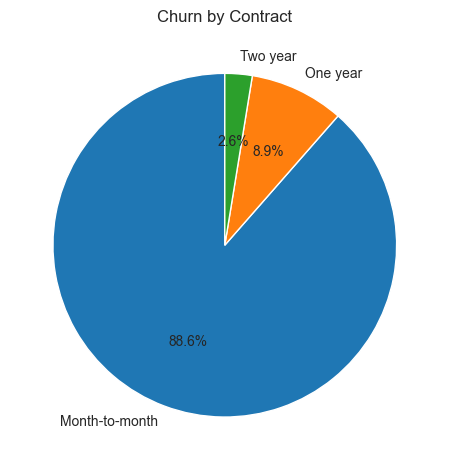

In [28]:

df1 = df['Contract'][df['Churn']=='Yes'].value_counts().reset_index()

plt.pie(df1['count'], labels=df1['Contract'],  autopct='%1.1f%%', startangle=90)
plt.title('Churn by Contract')
plt.tight_layout()
plt.show()

<div style='border: 1px solid #ddd; padding: 10px; border-radius: 5px; background-color:#f9f9f9'>
    <ul>
        <li> A greater tenure with the provider correlates with a lower likelihood of churn.</li>
        <li> Many customers ended their subscriptions after only one month.</li>
        <li> Many customers have been with the provider for a duration of 72 weeks.</li>
        <li> Longer contract terms correlate with longer customer retention (higher average score)</li>
    </ul>
</div>


## 3. Pre Processing

In [38]:
from sklearn.preprocessing import StandardScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline

In [39]:
# Re-categorize Churn column
# This line maps the 'Churn' column values from 'No' and 'Yes' to 0 and 1, respectively.
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

In [40]:
# Configuring transformers for the columns
# This section defines a ColumnTransformer that applies different transformations to specific columns in the DataFrame.

col_transformers = ColumnTransformer([
    # Apply StandardScaler to the specified numerical columns to scale the values
    ('sc', StandardScaler(), ['MonthlyCharges', 'TotalCharges', 'tenure']),
    
    # Apply OneHotEncoder for binary categorical columns, dropping one category to avoid multicollinearity
    ('binary', OneHotEncoder(drop='if_binary'), ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']),
    
    # Apply OneHotEncoder to non-binary categorical columns, dropping the first category to avoid the "dummy variable trap"
    ('enc_1', OneHotEncoder(drop='first'), ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']),
    
    # Apply OneHotEncoder to categorical columns without dropping any categories
    ('enc_2', OneHotEncoder(), ['Contract', 'PaymentMethod'])
])

## 4. Modelamiento

In [43]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve

In [44]:
# Definimos X e y
X = df.drop(columns=['Churn'])
y = df[['Churn']]

In [46]:
# Creating a list of models to evaluate
models = []
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('LD', LinearDiscriminantAnalysis()))
models.append(('DT', DecisionTreeClassifier(random_state=seed)))
models.append(('GB', GaussianNB()))
models.append(('RF', RandomForestClassifier(random_state=seed)))
models.append(('SVM', SVC(random_state=seed)))
models.append(('XGB', XGBClassifier(random_state=seed)))
models.append(('LGB', LGBMClassifier(random_state=seed, force_row_wise=True, verbose=-1)))

In [47]:
# Iterate through the list of models to evaluate each one
names = []  # List to store the names of the models
results = []  # List to store the performance scores of the models

# Loop through each model in the 'models' list
for model_name, model in models:
    
    # Create the pipeline with transformers and the model
    pipeline = Pipeline([
        ('transformers', col_transformers),  # Preprocessing steps for the features (e.g., scaling, encoding)
        ('model', model)  # The classification model being used
    ])

    # Configure the KFold cross-validation with 20 splits
    cv = KFold(n_splits=20, shuffle=True, random_state=seed)

    # Perform cross-validation with the pipeline, using accuracy as the evaluation metric
    scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')

    # Store the model name and its cross-validation scores
    names.append(model_name)
    results.append(scores)

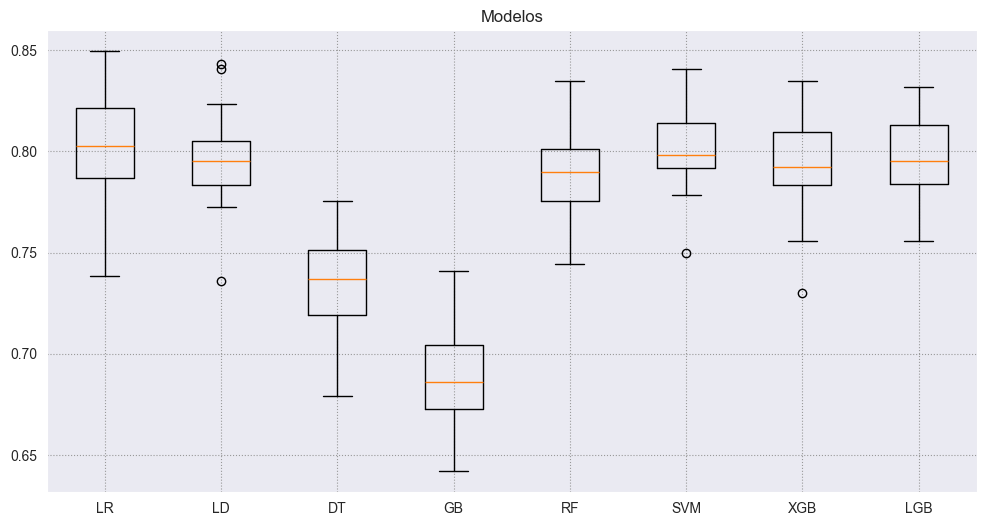

In [51]:
# Visualizing the results with a boxplot
plt.figure(figsize=(12,6))
plt.boxplot(results)
plt.xticks(range(1,len(names)+1), names)
plt.title('Modelos')
plt.show()

- Consideraremos `LR`, `LD`, `RF`, `SVM`, `XGB` y `LGB`.

In [ ]:
# Split X (features) and y (target) into training and testing sets for future model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed, stratify=y)

### 4.1 Logistic Regression

In [53]:
# Running LogisticRegression
lr_model = LogisticRegression(random_state=seed)
pipeline_LR = Pipeline([
    ('transformers', col_transformers),  # Data transformation step
    ('model', lr_model)  # Logistic Regression model
])

# Training the model
pipeline_LR.fit(X_train, y_train)

Pipeline(steps=[('transformers',
                 ColumnTransformer(transformers=[('sc', StandardScaler(),
                                                  ['MonthlyCharges',
                                                   'TotalCharges', 'tenure']),
                                                 ('binary',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'PaperlessBilling']),
                                                 ('enc_1',
                                                  OneHotEncoder(drop='first'),
                                                  ['MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies']),
                                                 ('enc_2', OneHotEncoder(),
                                                  ['Contract',
                                                   'PaymentMethod'])])),
                ('model', LogisticRegression(random_state=42))])

In [54]:
metricas(pipeline_LR, X_train, X_test, y_train, y_test)

,Accuracy,Precision,Recall
Train,0.804892,0.658994,0.551355
Test,0.805461,0.652068,0.573876


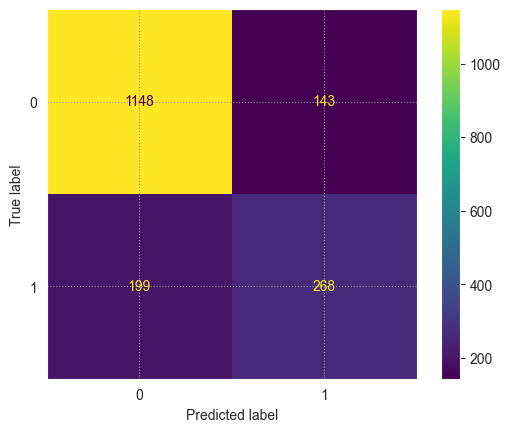

In [55]:
cm = confusion_matrix(y_true=y_test, y_pred=pipeline_LR.predict(X_test))
cm_plot = ConfusionMatrixDisplay(cm)
cm_plot.plot()
plt.show()

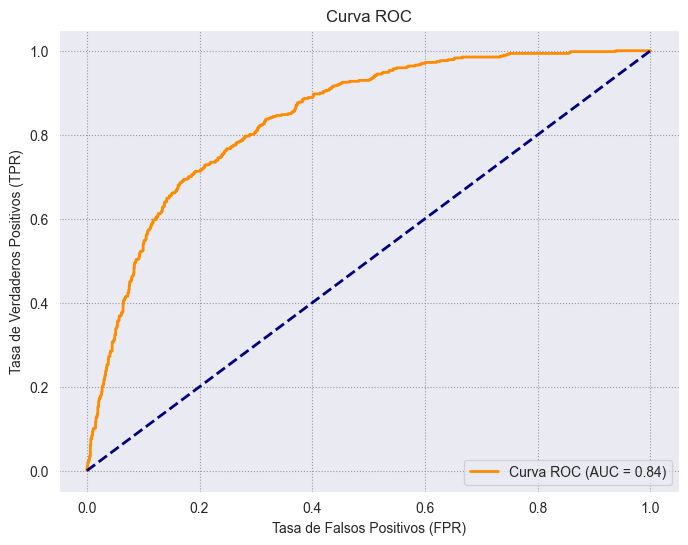

In [56]:
# Curva ROC Logistic Regression
curva_roc(pipeline_LR, X_test, y_test)

<div style='border: 1px solid #ddd; padding: 10px; border-radius: 5px; background-color:#f9f9f9'>
    <ul>
        The <b>Logistic Regression</b> model performs well on both the training and test sets, with a <mark>precision</mark> of 65.9% on the training set and 65.2% on the test set, indicating that the model is quite effective at correctly predicting positive cases in the majority of examples. Additionally, the <mark>recall</mark> is around 55.1% for the training set and 57.4% for the test set, suggesting that the model is moderately good at identifying positive cases, but there is still room for improvement, as it is not capturing all positive cases.
    </ul>
    <ul>
        The <mark>accuracy of about 80.5%</mark> on both the training and test sets reflects a strong overall performance of the model, meaning that the model classifies most observations correctly. Furthermore, the ROC Curve score of 0.84 is quite high, indicating that the model strikes a good balance between the true positive rate and the false positive rate, making it a reliable tool for binary classification.
    </ul>
</div>

### 4.2 Linear Discrimination Analysis

In [57]:
# Running LDA Model
lda_model =  LinearDiscriminantAnalysis()
pipeline_LDA = Pipeline([
    ('transformadores', col_transformers),
    ('model', lda_model)
])

# Training the model
pipeline_LDA.fit(X_train, y_train)

Pipeline(steps=[('transformadores',
                 ColumnTransformer(transformers=[('sc', StandardScaler(),
                                                  ['MonthlyCharges',
                                                   'TotalCharges', 'tenure']),
                                                 ('binary',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'PaperlessBilling']),
                                                 ('enc_1',
                                                  OneHotEncoder(drop='first'),
                                                  ['MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies']),
                                                 ('enc_2', OneHotEncoder(),
                                                  ['Contract',
                                                   'PaymentMethod'])])),
                ('model', LinearDiscriminantAnalysis())])

In [58]:
# Metrics
metricas(pipeline_LDA, X_train, X_test, y_train, y_test)

,Accuracy,Precision,Recall
Train,0.797687,0.637183,0.554922
Test,0.798635,0.631090,0.582441


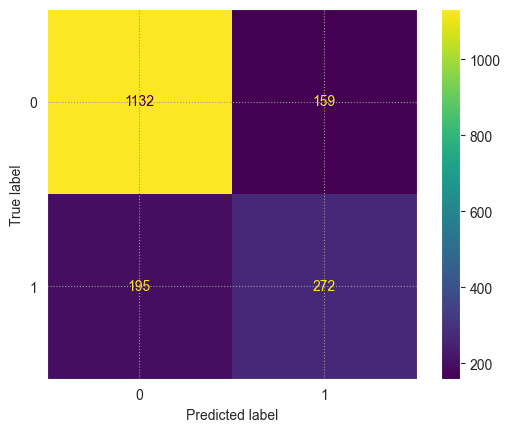

In [59]:
# Matriz de Confusion
cm = confusion_matrix(y_true=y_test, y_pred=pipeline_LDA.predict(X_test))
cm_plot = ConfusionMatrixDisplay(cm)
cm_plot.plot()
plt.show()

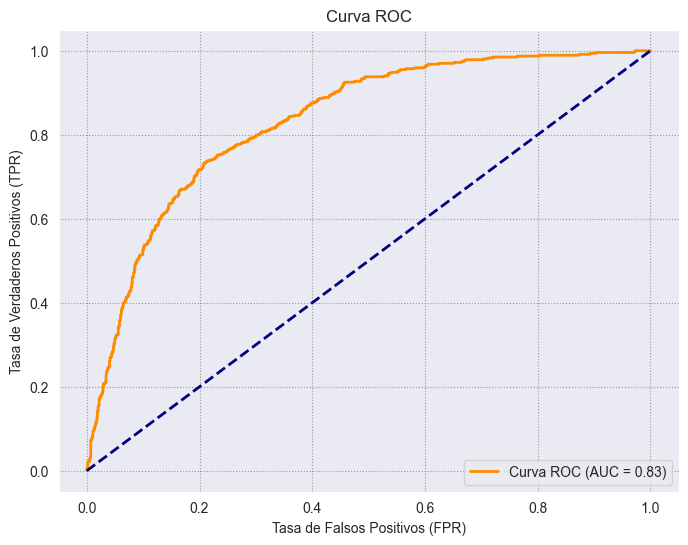

In [60]:
# Curva Roc LDA
curva_roc(pipeline_LDA, X_test, y_test)

<div style='border: 1px solid #ddd; padding: 10px; border-radius: 5px; background-color:#f9f9f9'>
    <ul>
        The <b>Linear Discriminant Analysis (LDA)</b> model performs well on both the training and test sets. The <mark>precision</mark> is 63.7% on the training set and 63.1% on the test set, indicating that the model is correctly classifying a good proportion of positive cases in both datasets. Additionally, the <mark>recall</mark> is around 55.5% in the training set and 58.2% in the test set, suggesting that the model has a moderate performance in identifying positive cases, but there is still room for improvement in covering all the positives.
    </ul>
    <ul>
        The <mark>accuracy of about 79.8%</mark> in both training and test sets reflects a strong overall classification, as the model is correctly predicting the majority of observations. Furthermore, the ROC Curve score of 0.83 is quite high, indicating that the model strikes a good balance between the true positive rate and the false positive rate, making it reliable for binary classification tasks.
    </ul>
</div>


### 4.3 Random Forest

In [61]:
# Running Random Forest Model
rf_model = RandomForestClassifier(
    n_estimators=1000,
    oob_score=True,
    random_state=seed,
    max_leaf_nodes=30,
    criterion='gini',
    min_samples_split=4)

pipeline_RF = Pipeline([
    ('transformadores', col_transformers),
    ('model', rf_model)
])

# Training the Model
pipeline_RF.fit(X_train, y_train)

Pipeline(steps=[('transformadores',
                 ColumnTransformer(transformers=[('sc', StandardScaler(),
                                                  ['MonthlyCharges',
                                                   'TotalCharges', 'tenure']),
                                                 ('binary',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'PaperlessBilling']),
                                                 ('enc_1',
                                                  OneHotEncoder(drop='first'),
                                                  ['MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies']),
                                                 ('enc_2', OneHotEncoder(),
                                                  ['Contract',
                                                   'PaymentMethod'])])),
                ('model',
                 RandomForestClassifier(max_leaf_nodes=30, min_samples_split=4,
                                        n_estimators=1000, oob_score=True,
                                        random_state=42))])

In [62]:
# Metrics
metricas(pipeline_RF, X_train, X_test, y_train, y_test)

,Accuracy,Precision,Recall
Train,0.815131,0.710345,0.514265
Test,0.792378,0.652695,0.466809


In [67]:
X_col = col_transformers.get_feature_names_out().tolist()
X_col = [x.replace('sc__', '').replace('binary__', '').replace('enc_1__', '').replace('enc_2__', '') for x in X_col]

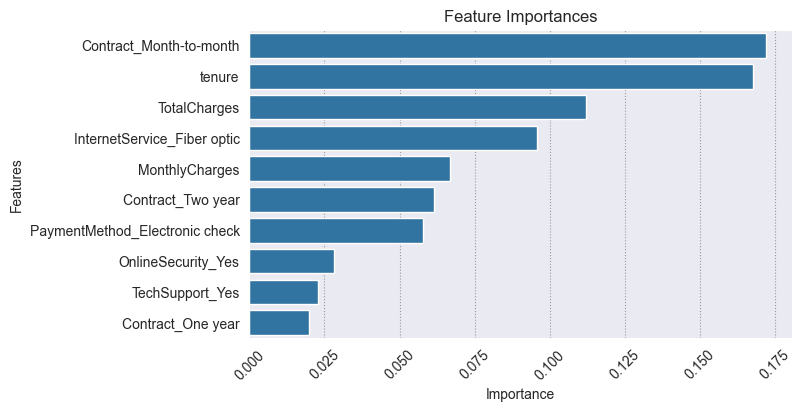

In [68]:
importance_features =   pd.DataFrame(zip( X_col,pipeline_RF.named_steps['model'].feature_importances_),
                        columns=['Features','Importance']).sort_values(by='Importance', ascending=False)

#Graficamos las Variables
plt.figure(figsize=(7,4))
sns.barplot(x='Importance', y='Features', data=importance_features[:10])
plt.title('Feature Importances')
plt.xticks(rotation=45)
plt.show()

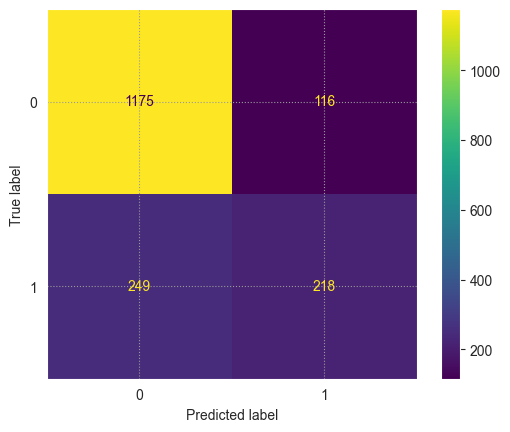

In [65]:
cm = confusion_matrix(y_true=y_test, y_pred=pipeline_RF.predict(X_test))
cm_plot = ConfusionMatrixDisplay(cm)
cm_plot.plot()
plt.show()

<div style='border: 1px solid #ddd; padding: 10px; border-radius: 5px; background-color:#f9f9f9'>
    <ul>
        The <b>Random Forest</b> model shows strong performance on both the training and test sets. In terms of <mark>precision</mark>, the model achieves 71.0% on the training set and 65.3% on the test set, indicating that most positive predictions are correct, though performance on the test set is somewhat lower, which may reflect overfitting on the training set. The <mark>recall</mark> is 51.4% on training and 46.7% on test, suggesting that the model is identifying a moderate number of positive cases, but there is room for improvement in covering all positives.
    </ul>
    <ul>
        The <mark>accuracy</mark> is 81.5% on training and 79.2% on test, which indicates that the model is good at predicting the correct classes, although there is a slight drop on the test set, which could indicate some lack of generalization. Regarding <mark>feature importance</mark>, the most influential features are: <mark>Contract_Month-to-month, tenure, TotalCharges, and InternetService_Fiber optic</mark>, highlighting that factors such as contract type, service duration, and internet plan characteristics play a crucial role in predicting customer churn.
    </ul>
</div>

### 4.4 Support Vector Machine

In [72]:
# Running SVC Model
svm_model = SVC(random_state=seed, kernel='poly', probability=True)
pipeline_SVM = Pipeline([
    ('transformadores', col_transformers),
    ('model', svm_model)
])

# Training the model
pipeline_SVM.fit(X_train, y_train)

Pipeline(steps=[('transformadores',
                 ColumnTransformer(transformers=[('sc', StandardScaler(),
                                                  ['MonthlyCharges',
                                                   'TotalCharges', 'tenure']),
                                                 ('binary',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'PaperlessBilling']),
                                                 ('enc_1',
                                                  OneHotEncoder(drop='first'),
                                                  ['MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies']),
                                                 ('enc_2', OneHotEncoder(),
                                                  ['Contract',
                                                   'PaymentMethod'])])),
                ('model',
                 SVC(kernel='poly', probability=True, random_state=42))])

In [73]:
# Metrics
metricas(pipeline_SVM, X_train, X_test, y_train, y_test)

,Accuracy,Precision,Recall
Train,0.817785,0.727554,0.502853
Test,0.795222,0.662614,0.466809


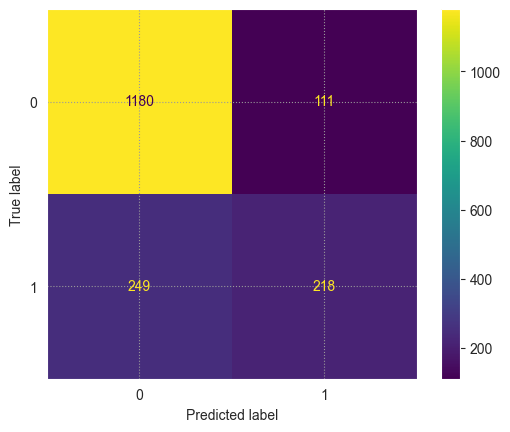

In [74]:
# Confusion Matrix
cm = confusion_matrix(y_true=y_test, y_pred=pipeline_SVM.predict(X_test))
cm_plot = ConfusionMatrixDisplay(cm)
cm_plot.plot()
plt.show()

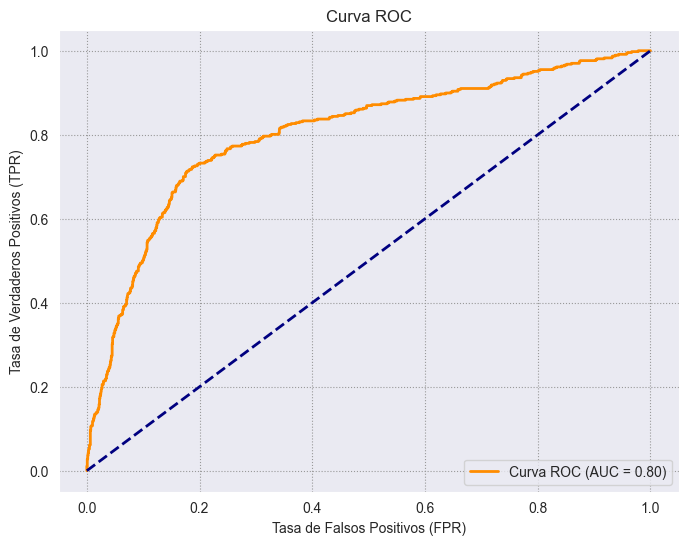

In [75]:
# Curva ROC
curva_roc(pipeline_SVM, X_test, y_test)

<div style='border: 1px solid #ddd; padding: 10px; border-radius: 5px; background-color:#f9f9f9'>
    <ul>
        The <b>Support Vector Classifier (SVC)</b> model, with a polynomial kernel, shows good performance on both the training and test sets. In terms of <mark>precision</mark>, the model achieves 72.8% on the training set and 66.3% on the test set, indicating that the model is quite precise in making positive predictions, although there is a slight drop in precision on the test set, which might suggest some overfitting on the training data.
    </ul>
    <ul>
        The <mark>recall</mark> is 50.3% on training and 46.7% on test, showing that the model is moderately able to identify positive cases, but there is still room for improvement in detecting all relevant cases. The <mark>accuracy</mark> is 81.8% on training and 79.5% on test, suggesting that the model is making correct predictions in most cases, although the difference between training and test sets indicates some overfitting. The ROC curve is 0.80, indicating reasonably good performance in classifying the classes.
    </ul>
</div>

### 4.5 XGB

In [76]:
# Running XGB Model
xgb_model = XGBClassifier(
    random_state=seed,
    n_estimators=1000,
    max_depth=3,
    learning_rate=0.01,
    booster='dart')

pipeline_XGB = Pipeline([
    ('transformadores', col_transformers),
    ('model', xgb_model)
])

# Training the model
pipeline_XGB.fit(X_train, y_train)

Pipeline(steps=[('transformadores',
                 ColumnTransformer(transformers=[('sc', StandardScaler(),
                                                  ['MonthlyCharges',
                                                   'TotalCharges', 'tenure']),
                                                 ('binary',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'PaperlessBilling']),
                                                 ('enc_1',
                                                  OneHotEncoder(drop='first'),
                                                  ['MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=1000, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [77]:
# Metricas
metricas(pipeline_XGB, X_train, X_test, y_train, y_test)

,Accuracy,Precision,Recall
Train,0.820630,0.705036,0.559201
Test,0.801479,0.656915,0.528908


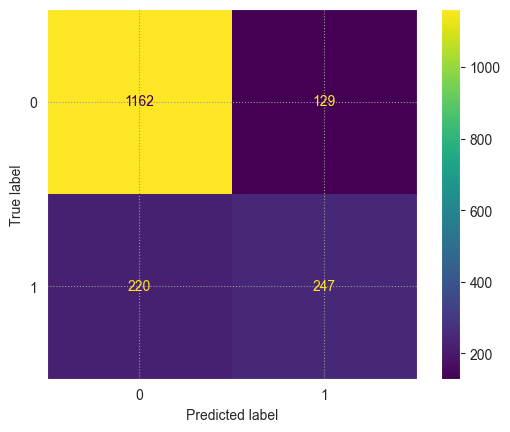

In [78]:
cm = confusion_matrix(y_true=y_test, y_pred=pipeline_XGB.predict(X_test))
cm_plot = ConfusionMatrixDisplay(cm)
cm_plot.plot()
plt.show()

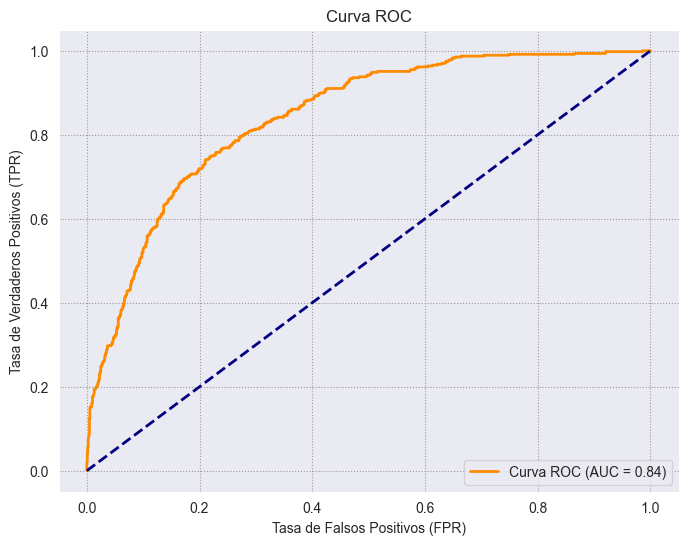

In [79]:
curva_roc(pipeline_XGB, X_test, y_test)

<div style='border: 1px solid #ddd; padding: 10px; border-radius: 5px; background-color:#f9f9f9'>
    <ul>
        The <b>XGBoost (XGB)</b> model, with a learning rate of 0.01, 1000 estimators, and a maximum tree depth of 3, shows outstanding performance. In terms of <mark>precision</mark>, it achieves 70.5% on the training set and 65.7% on the test set. This indicates that the model is precise in making positive predictions, with a slight drop in precision when transitioning from training to testing, which could suggest some overfitting.
    </ul>
    <ul>
        The <mark>xrecall</mark> is 55.9% in training and 52.9% in testing, indicating that the model has a reasonable ability to identify positive cases, though it could be improved to capture more of these relevant cases. The <mark>accuracy</mark> is 82.1% in training and 80.1% in testing, suggesting that the model makes a high proportion of correct predictions, though with a slight difference between the training and test sets, which could also reflect some overfitting. Finally, the ROC curve is 0.84, indicating excellent model performance in distinguishing between the classes, showing very solid classification performance.
    </ul>
</div>

### 4.6 LGB

In [80]:
# Running LGB Model
lgb_model = LGBMClassifier(
    random_state=seed,
    learning_rate=0.01,
    max_depth=3,
    n_estimators=1000)

pipeline_LGB = Pipeline([
    ('transformadores', col_transformers),
    ('model', lgb_model)
])

# Training the model
pipeline_LGB.fit(X_train, y_train)


Pipeline(steps=[('transformadores',
                 ColumnTransformer(transformers=[('sc', StandardScaler(),
                                                  ['MonthlyCharges',
                                                   'TotalCharges', 'tenure']),
                                                 ('binary',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'PaperlessBilling']),
                                                 ('enc_1',
                                                  OneHotEncoder(drop='first'),
                                                  ['MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies']),
                                                 ('enc_2', OneHotEncoder(),
                                                  ['Contract',
                                                   'PaymentMethod'])])),
                ('model',
                 LGBMClassifier(learning_rate=0.01, max_depth=3,
                                n_estimators=1000, random_state=42))])

In [81]:
# Metrics
metricas(pipeline_LGB, X_train, X_test, y_train, y_test)

,Accuracy,Precision,Recall
Train,0.822336,0.708895,0.562767
Test,0.797497,0.648000,0.520343


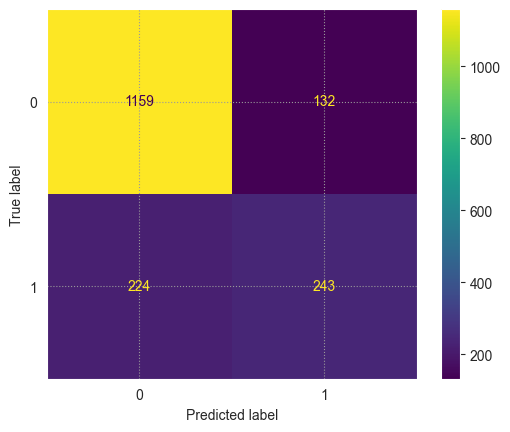

In [82]:
cm = confusion_matrix(y_true=y_test, y_pred=pipeline_LGB.predict(X_test))
cm_plot = ConfusionMatrixDisplay(cm)
cm_plot.plot()
plt.show()

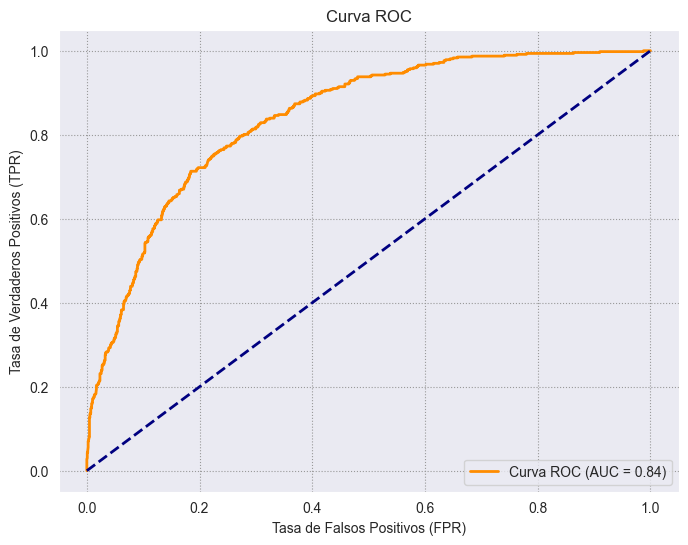

In [83]:
curva_roc(pipeline_LGB, X_test, y_test)

<div style='border: 1px solid #ddd; padding: 10px; border-radius: 5px; background-color:#f9f9f9'>
    <ul>
        The <b>LightGBM (LGB)</b> model, configured with a learning rate of 0.01, a maximum depth of 3, and 1000 estimators, demonstrates solid performance in the classification task. On the training set, the model achieves an <mark>accuracy</mark> of 82.2%, a <mark>precision</mark> of 70.9%, and a <mark>recall</mark> of 56.3%, indicating a good balance between correctly predicting and recovering positive cases.
    </ul>
    <ul>    
        On the test set, the model achieves an accuracy of 79.7%, a precision of 64.8%, and a recall of 52.0%. This reflects a slight decrease in performance from training to testing but remains fairly consistent, suggesting a well-generalized model. The ROC curve of 0.84 confirms excellent ability to distinguish between classes, making LightGBM a competitive choice for the task.
    </ul>
</div>

### 4.7 Stacking Classifier

In [84]:
from sklearn.ensemble import StackingClassifier

In [91]:
# Stacking Models
estimators = [
    ('LR', lr_model),
    ('LDA', lda_model),
    ('SVM', svm_model),
    ('XGB', xgb_model),
    ('LGB', lgb_model)
]

pipeline_stack = Pipeline([
    ('transformadores', col_transformers),
    ('stacking', StackingClassifier(
        estimators=estimators,
        final_estimator=lr_model
    ))
])

# Training el Modelo
pipeline_stack.fit(X_train, y_train)

Pipeline(steps=[('transformadores',
                 ColumnTransformer(transformers=[('sc', StandardScaler(),
                                                  ['MonthlyCharges',
                                                   'TotalCharges', 'tenure']),
                                                 ('binary',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'PaperlessBilling']),
                                                 ('enc_1',
                                                  OneHotEncoder(drop='first'),
                                                  ['MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',...
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=3,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=1000,
                                                               n_jobs=None,
                                                               num_parallel_tree=None,
                                                               random_state=42, ...)),
                                                ('LGB',
                                                 LGBMClassifier(learning_rate=0.01,
                                                                max_depth=3,
                                                                n_estimators=1000,
                                                                random_state=42))],
                                    final_estimator=LogisticRegression(random_state=42)))])

In [92]:
# Metricas
metricas(pipeline_stack, X_train, X_test, y_train, y_test)

,Accuracy,Precision,Recall
Train,0.812287,0.677586,0.560628
Test,0.810011,0.665012,0.573876


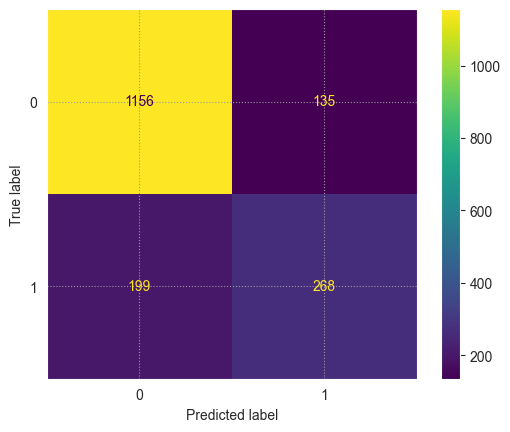

In [93]:
cm = confusion_matrix(y_true=y_test, y_pred=pipeline_stack.predict(X_test))
cm_plot = ConfusionMatrixDisplay(cm)
cm_plot.plot()
plt.show()

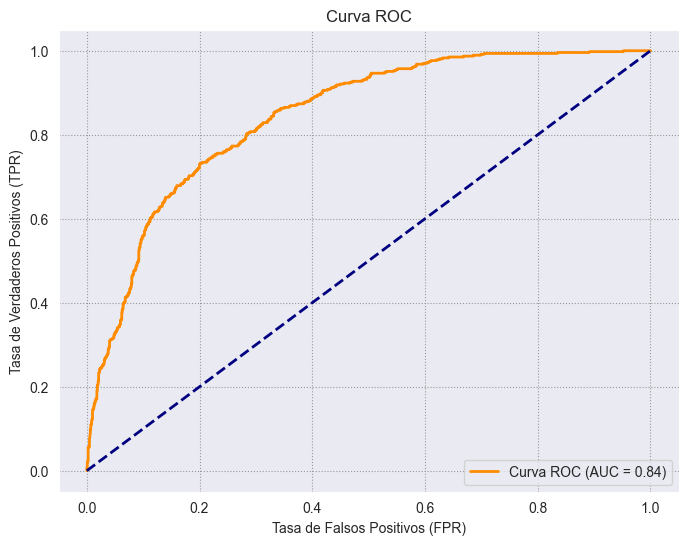

In [94]:
curva_roc(pipeline_stack, X_test, y_test)

<div style='border: 1px solid #ddd; padding: 10px; border-radius: 5px; background-color:#f9f9f9'>
    <ul>
        The <b>StackingClassifier</b>, which combines multiple base algorithms (Logistic Regression, LDA, SVM, XGBoost, and LightGBM) using <b>Logistic Regression</b> as the final estimator, demonstrates excellent performance in the classification task. This approach leverages the strengths of different models to enhance overall predictive ability.
    </ul>
    <ul>
        On the training set, the model achieves an <mark>accuracy</mark> of 81.2%, a <mark>precision</mark> of 67.8%, and a <mark>recall</mark> of 56.1%, indicating a good balance between accuracy and the ability to recover positive cases. On the test set, it achieves an <mark>accuracy</mark> of 81.0%, a <mark>precision</mark> of 66.5%, and a <mark>recall</mark> of 57.4%. These results reflect a well-generalized model with robust performance on unseen data.
    </ul>
    <ul>
        The <mark>ROC curve</mark> of 0.84 confirms the model's strong ability to distinguish between classes, showing that the stacking approach enhances performance by combining complementary models.
    </ul>
</div>

### 4.8 Voting Classifier

In [95]:
from sklearn.ensemble import VotingClassifier

In [97]:
# Voting Classifier
estimators = [
    ('LR', lr_model),
    ('LDA', lda_model),
    ('SVM', svm_model),
    ('XGB', xgb_model),
    ('LGB', lgb_model)
]

# Creamos el pipeline
pipeline_voting = Pipeline([
    ('transformadores', col_transformers),
    ('estimator', VotingClassifier(
        estimators=estimators, voting='hard'))
])

# Training el Modelo
pipeline_voting.fit(X_train, y_train)

Pipeline(steps=[('transformadores',
                 ColumnTransformer(transformers=[('sc', StandardScaler(),
                                                  ['MonthlyCharges',
                                                   'TotalCharges', 'tenure']),
                                                 ('binary',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'PaperlessBilling']),
                                                 ('enc_1',
                                                  OneHotEncoder(drop='first'),
                                                  ['MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',...
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=3,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=1000,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=42, ...)),
                                              ('LGB',
                                               LGBMClassifier(learning_rate=0.01,
                                                              max_depth=3,
                                                              n_estimators=1000,
                                                              random_state=42))]))])

In [98]:
# Metricas
metricas(pipeline_voting, X_train, X_test, y_train, y_test)

,Accuracy,Precision,Recall
Train,0.817217,0.704291,0.538516
Test,0.800910,0.658537,0.520343


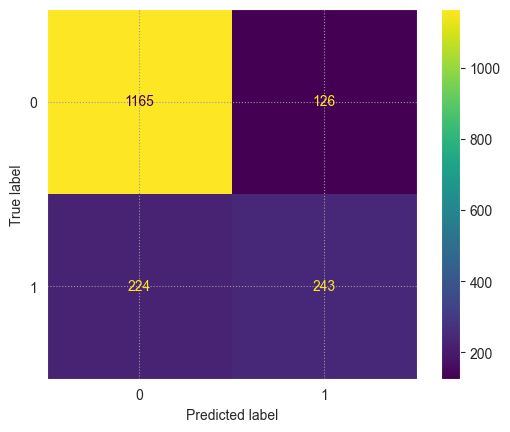

In [99]:
cm = confusion_matrix(y_true=y_test, y_pred=pipeline_voting.predict(X_test))
cm_plot = ConfusionMatrixDisplay(cm)
cm_plot.plot()
plt.show()

<div style='border: 1px solid #ddd; padding: 10px; border-radius: 5px; background-color:#f9f9f9'>
    <ul>
        The <b>VotingClassifier</b>, which combines several base estimators (Logistic Regression, LDA, SVM, XGBoost, and LightGBM) through a majority voting approach (<b>voting='hard'</b>), delivers solid and consistent results in the classification task.
    </ul>
    <ul>  
        On the training set, the model achieves an accuracy of 81.7%, a precision of 70.4%, and a recall of 53.8%, indicating a good balance in its ability to correctly classify both positives and negatives. On the test set, it reaches an accuracy of 80.1%, a precision of 65.9%, and a recall of 52.0%, showcasing strong overall performance on unseen data.
    </ul>
    <ul>
        This approach is effective in combining multiple complementary models, increasing stability, and reducing the risk of relying on a single model. While it doesn't outperform models like StackingClassifier in terms of recall, it remains a reliable and efficient strategy for classification tasks.
    </ul>
</div>

## 5. Final Model

In [101]:
metricas(pipeline_stack, X_train, X_test, y_train, y_test)

,Accuracy,Precision,Recall
Train,0.812287,0.677586,0.560628
Test,0.810011,0.665012,0.573876


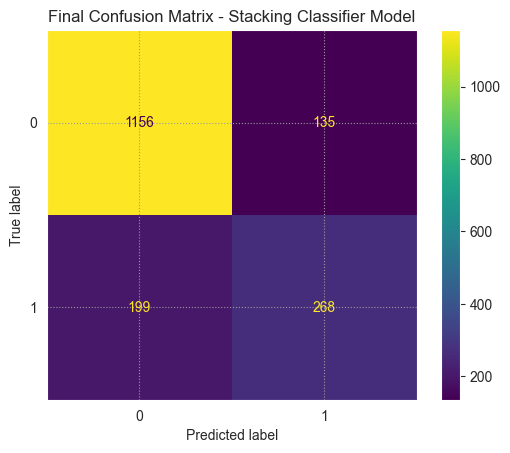

In [102]:
# Final ConfusionMatrix
cm = confusion_matrix(y_true=y_test, y_pred=pipeline_stack.predict(X_test))
cm_plot = ConfusionMatrixDisplay(cm)
cm_plot.plot()
plt.title('Final Confusion Matrix - Stacking Classifier Model')
plt.show()

## 6.Final Summary

<div style="border: 1px solid #ddd; padding: 15px; border-radius: 5px; background-color: #f9f9f9;">
    <p>
        Throughout this analysis, we evaluated several supervised learning algorithms to predict the <b>Churn</b> variable in our dataset. The tested models included 
        <b>Logistic Regression</b>, <b>Linear Discriminant Analysis (LDA)</b>, <b>Random Forest</b>, <b>Support Vector Machine (SVM)</b>, <b>XGBoost</b>, <b>LightGBM</b>, and combined approaches such as <b>StackingClassifier</b> and <b>VotingClassifier</b>.
    </p>
    <p>
        The results showed that individual models like <b>XGBoost</b> and <b>LightGBM</b> achieved a good balance between precision, recall, and ROC-AUC, standing out among the base models. However, combined approaches delivered better overall performance:
    </p>
    <ul>
        <li>
            <b>StackingClassifier</b> was the most robust model, achieving the best performance in terms of <b>accuracy (81.0%)</b> and <b>recall (57.4%)</b> on the test set, with a <b>ROC-AUC of 0.84</b>. This model effectively combines the strengths of several algorithms, maximizing predictive capacity.
        </li>
        <li>
            <b>VotingClassifier</b> also demonstrated competitive performance with an <b>accuracy (80.1%)</b> and <b>recall (52.0%)</b>, serving as a reliable alternative, though slightly inferior to the stacking approach.
        </li>
    </ul>
    <p>
        In conclusion, the <b>StackingClassifier</b> model is selected as the final model due to its superior performance and consistency across key metrics. This model leverages the complementarity of multiple algorithms to optimize <b>Churn</b> prediction, representing the best solution for this problem.
    </p>
</div>
